# Basic `optimex` Example

This notebook demonstrates the core `optimex` workflow using dummy processes — no external databases required.

We set up a simple system with **two products**, each producible via **two alternative routes**, and let `optimex` find the climate-optimal transition pathway.

The pipeline follows four steps:

1. **Database setup** — biosphere, background, and foreground in Brightway
2. **LCA processing** — extract time-explicit LCA data
3. **Optimization** — find the cost-optimal deployment schedule
4. **Post-processing** — visualize results


## 1. Database Setup

We create a standalone Brightway project with:

- A **biosphere** database (CO2, CH4, land occupation)
- Three **background databases** at different points in time (2020, 2035, 2050) representing evolving supply chains
- A **foreground** database with our decision-relevant processes


In [ ]:
from datetime import datetime
import numpy as np
import bw2data as bd
from bw_temporalis import TemporalDistribution, easy_timedelta_distribution

bd.projects.set_current("optimex_basic_example")

### Biosphere

Elementary flows that processes can emit or consume. When using ecoinvent, this is already available.


In [2]:
biosphere_data = {
    ("biosphere3", "CO2"): {
        "type": bd.labels.biosphere_node_default,
        "name": "carbon dioxide",
        "CAS number": "000124-38-9",
    },
    ("biosphere3", "CH4"): {
        "type": bd.labels.biosphere_node_default,
        "name": "methane, fossil",
        "CAS number": "000074-82-8",
    },
    ("biosphere3", "land_occupation"): {
        "type": bd.labels.biosphere_node_default,
        "name": "land occupation",
    },
}
bd.Database("biosphere3").write(biosphere_data)

100%|██████████| 3/3 [00:00<00:00, 28276.21it/s]

10:34:28+0100 [info     ] Vacuuming database            


### Characterization Methods

Maps elementary flows to impact scores. With ecoinvent, standard methods (IPCC, ReCiPe, ...) are pre-loaded.


In [3]:
bd.Method(("GWP", "example")).write(
    [
        (("biosphere3", "CO2"), 1),
        (("biosphere3", "CH4"), 27),
    ]
)

bd.Method(("land use", "example")).write(
    [
        (("biosphere3", "land_occupation"), 1),
        (("biosphere3", "CH4"), 27),
    ]
)

### Background Databases

Background processes supply inputs to the foreground but are not decision variables. To model technological evolution, we provide **multiple snapshots** at different years. `optimex` interpolates between them.

Each database needs `representative_time` metadata so `optimex` knows which year it represents. In practice, tools like [premise](https://github.com/polca/premise) generate these from IAM scenarios.


In [4]:
# Background 2020
db_2020_data = {
    ("db_2020", "I1"): {
        "name": "node I1",
        "location": "somewhere",
        "type": bd.labels.chimaera_node_default,
        "reference product": "I1",
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("db_2020", "I1"),
            },
            {
                "amount": 3000,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
            },
        ],
    },
    ("db_2020", "I2"): {
        "name": "node I2",
        "location": "somewhere",
        "type": bd.labels.chimaera_node_default,
        "reference product": "I2",
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("db_2020", "I2"),
            },
            {
                "amount": 5,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CH4"),
            },
        ],
    },
    ("db_2020", "I3"): {
        "name": "node I3",
        "location": "somewhere",
        "type": bd.labels.chimaera_node_default,
        "reference product": "I3",
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("db_2020", "I3"),
            },
            {
                "amount": 3,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CH4"),
            },
            {
                "amount": 10,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "land_occupation"),
            },
        ],
    },
}
bg_2020 = bd.Database("db_2020")
bg_2020.write(db_2020_data)
bg_2020.metadata["representative_time"] = datetime(2020, 1, 1).isoformat()
bg_2020.register()

# Background 2035 — lower emissions reflecting technological progress
db_2035_data = {
    ("db_2035", "I1"): {
        "name": "node I1",
        "location": "somewhere",
        "type": bd.labels.chimaera_node_default,
        "reference product": "I1",
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("db_2035", "I1"),
            },
            {
                "amount": 2500,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
            },
        ],
    },
    ("db_2035", "I2"): {
        "name": "node I2",
        "location": "somewhere",
        "type": bd.labels.chimaera_node_default,
        "reference product": "I2",
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("db_2035", "I2"),
            },
            {
                "amount": 2,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CH4"),
            },
        ],
    },
    ("db_2035", "I3"): {
        "name": "node I3",
        "location": "somewhere",
        "type": bd.labels.chimaera_node_default,
        "reference product": "I3",
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("db_2035", "I3"),
            },
            {
                "amount": 2,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CH4"),
            },
            {
                "amount": 7,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "land_occupation"),
            },
        ],
    },
}
bg_2035 = bd.Database("db_2035")
bg_2035.write(db_2035_data)
bg_2035.metadata["representative_time"] = datetime(2035, 1, 1).isoformat()
bg_2035.register()

# Background 2050 — further improvements
db_2050_data = {
    ("db_2050", "I1"): {
        "name": "node I1",
        "location": "somewhere",
        "type": bd.labels.chimaera_node_default,
        "reference product": "I1",
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("db_2050", "I1"),
            },
            {
                "amount": 2200,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
            },
        ],
    },
    ("db_2050", "I2"): {
        "name": "node I2",
        "location": "somewhere",
        "type": bd.labels.chimaera_node_default,
        "reference product": "I2",
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("db_2050", "I2"),
            },
            {
                "amount": 1,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CH4"),
            },
        ],
    },
    ("db_2050", "I3"): {
        "name": "node I3",
        "location": "somewhere",
        "type": bd.labels.chimaera_node_default,
        "reference product": "I3",
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("db_2050", "I3"),
            },
            {
                "amount": 1,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CH4"),
            },
            {
                "amount": 7,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "land_occupation"),
            },
        ],
    },
}
bg_2050 = bd.Database("db_2050")
bg_2050.write(db_2050_data)
bg_2050.metadata["representative_time"] = datetime(2050, 1, 1).isoformat()
bg_2050.register()

10:34:28+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 3/3 [00:00<00:00, 49152.00it/s]

10:34:28+0100 [info     ] Vacuuming database            
10:34:28+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.



100%|██████████| 3/3 [00:00<00:00, 54471.48it/s]

10:34:28+0100 [info     ] Vacuuming database            
10:34:28+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.



100%|██████████| 3/3 [00:00<00:00, 59074.70it/s]

10:34:28+0100 [info     ] Vacuuming database            


### Foreground Database

The foreground contains the **decision-relevant processes** whose installation and operation timing `optimex` optimizes.

Key `optimex`-specific attributes on processes and exchanges:

- **`operation_time_limits`**: tuple `(start, end)` defining the operation phase within a process lifetime
- **`temporal_distribution`**: when each exchange occurs relative to installation (using `TemporalDistribution`)
- **`operation: True`**: marks exchanges that scale with operational level (production, operational emissions)

Our system has two products, each with two production routes:

- **Product 1**: Route 1 (6-year operation, uses I1+I3, captures CO2 during operation) vs. Route 2 (11-year operation, uses I2+I3, captures CO2 during operation)
- **Product 2**: Route 1 (15-year operation, needs Product 1, uses I3, emits CO2) vs. Route 2 (7-year operation, needs Product 1, uses I2, captures CO2 during operation)


In [5]:
if "foreground" in bd.databases:
    del bd.databases["foreground"]
foreground = bd.Database("foreground")
foreground.register()

In [6]:
foreground_data = {
    # --- Product 1 and its two production routes ---
    ("foreground", "Product 1"): {
        "name": "Product 1",
        "unit": "kg",
        "type": bd.labels.product_node_default,
    },
    ("foreground", "P1R1"): {
        "name": "Product 1 production, Route 1",
        "location": "somewhere",
        "type": bd.labels.process_node_default,
        "operation_time_limits": (0, 6),
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("foreground", "Product 1"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1, end=6, steps=6, resolution="Y", kind="uniform"
                ),
                "operation": True,
            },
            {
                "amount": 27.5,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I1"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array([11], dtype="timedelta64[Y]"), amount=np.array([1])
                ),
            },
            {
                "amount": 35,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I3"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array([11], dtype="timedelta64[Y]"), amount=np.array([1])
                ),
            },
            {
                "amount": -20,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1, end=6, steps=6, resolution="Y", kind="uniform"
                ),
                "operation": True,
            },
        ],
    },
    ("foreground", "P1R2"): {
        "name": "Product 1 production, Route 2",
        "location": "somewhere",
        "type": bd.labels.process_node_default,
        "operation_time_limits": (0, 11),
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("foreground", "Product 1"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1, end=11, steps=11, resolution="Y", kind="uniform"
                ),
                "operation": True,
            },
            {
                "amount": 10,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array([11], dtype="timedelta64[Y]"), amount=np.array([1])
                ),
            },
            {
                "amount": 5,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I3"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array([11], dtype="timedelta64[Y]"), amount=np.array([1])
                ),
            },
            {
                "amount": -20,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1, end=11, steps=11, resolution="Y", kind="uniform"
                ),
                "operation": True,
            },
        ],
    },
    # --- Product 2 and its two production routes ---
    ("foreground", "Product 2"): {
        "name": "Product 2",
        "unit": "kg",
        "type": bd.labels.product_node_default,
    },
    ("foreground", "P2R1"): {
        "name": "Product 2 production, Route 1",
        "location": "somewhere",
        "type": bd.labels.process_node_default,
        "operation_time_limits": (0, 15),
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("foreground", "Product 2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1, end=15, steps=15, resolution="Y", kind="uniform"
                ),
                "operation": True,
            },
            {
                "amount": 1,
                "type": bd.labels.consumption_edge_default,
                "input": ("foreground", "Product 1"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1, end=15, steps=15, resolution="Y", kind="uniform"
                ),
                "operation": True,
            },
            {
                "amount": 18.5,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I3"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array([0], dtype="timedelta64[Y]"), amount=np.array([1])
                ),
            },
            {
                "amount": 3,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1, end=15, steps=15, resolution="Y", kind="uniform"
                ),
                "operation": True,
            },
        ],
    },
    ("foreground", "P2R2"): {
        "name": "Product 2 production, Route 2",
        "location": "somewhere",
        "type": bd.labels.process_node_default,
        "operation_time_limits": (0, 7),
        "exchanges": [
            {
                "amount": 1,
                "type": bd.labels.production_edge_default,
                "input": ("foreground", "Product 2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1, end=7, steps=7, resolution="Y", kind="uniform"
                ),
                "operation": True,
            },
            {
                "amount": 1,
                "type": bd.labels.consumption_edge_default,
                "input": ("foreground", "Product 1"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1, end=7, steps=7, resolution="Y", kind="uniform"
                ),
                "operation": True,
            },
            {
                "amount": 15.5,
                "type": bd.labels.consumption_edge_default,
                "input": ("db_2020", "I2"),
                "temporal_distribution": TemporalDistribution(
                    date=np.array([0], dtype="timedelta64[Y]"), amount=np.array([1])
                ),
            },
            {
                "amount": -10,
                "type": bd.labels.biosphere_edge_default,
                "input": ("biosphere3", "CO2"),
                "temporal_distribution": easy_timedelta_distribution(
                    start=1, end=7, steps=7, resolution="Y", kind="uniform"
                ),
                "operation": True,
            },
        ],
    },
}

fg = bd.Database("foreground")
fg.write(foreground_data)
fg.register()

10:34:28+0100 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 6/6 [00:00<00:00, 10288.56it/s]

10:34:28+0100 [info     ] Vacuuming database            


### Demand

Define time-varying demand for Product 2 from 2025 to 2049. `optimex` will determine the optimal process mix to meet this demand each year.


In [7]:
years = range(2025, 2050)
rng = np.random.default_rng(42)

td_demand = TemporalDistribution(
    date=np.array(
        [datetime(year, 1, 1).isoformat() for year in years], dtype="datetime64[s]"
    ),
    amount=rng.random(len(years)) * 10,
)

functional_demand = {bd.get_node(database="foreground", name="Product 2"): td_demand}

## 2. LCA Processing

Configure the LCA: specify the demand, temporal settings, and characterization methods. The `LCADataProcessor` extracts all time-explicit LCA tensors needed for optimization.


In [8]:
from optimex import lca_processor

lca_config = lca_processor.LCAConfig(
    demand=functional_demand,
    temporal={
        "start_date": datetime(2020, 1, 1),
        "temporal_resolution": "year",
        "time_horizon": 100,
    },
    characterization_methods=[
        {
            "category_name": "climate_change",
            "brightway_method": ("GWP", "example"),
        },
    ],
)

lca_data_processor = lca_processor.LCADataProcessor(lca_config)

2026-02-11 10:34:28.200 | INFO     | optimex.lca_processor:_parse_demand:417 - Identified demand in system time range of %s for products %s
2026-02-11 10:34:28.204 | INFO     | optimex.lca_processor:_construct_foreground_tensors:639 - Constructed foreground tensors.
2026-02-11 10:34:28.204 | INFO     | optimex.lca_processor:log_tensor_dimensions:634 - Technosphere (external) shape: (4 processes, 3 flows, 2 years) with 6 total entries.
2026-02-11 10:34:28.204 | INFO     | optimex.lca_processor:log_tensor_dimensions:634 - Internal demand shape: (2 processes, 1 flows, 15 years) with 22 total entries.
2026-02-11 10:34:28.205 | INFO     | optimex.lca_processor:log_tensor_dimensions:634 - Biosphere shape: (4 processes, 1 flows, 15 years) with 39 total entries.
2026-02-11 10:34:28.205 | INFO     | optimex.lca_processor:log_tensor_dimensions:634 - Production shape: (4 processes, 2 flows, 15 years) with 39 total entries.
2026-02-11 10:34:28.205 | INFO     | optimex.lca_processor:_calculate_inve

### Convert to Optimization Inputs

The `ModelInputManager` converts LCA data into `OptimizationModelInputs`. These can be saved/loaded to avoid re-running the LCA step.


In [9]:
from optimex import converter

manager = converter.ModelInputManager()
optimization_model_inputs = manager.parse_from_lca_processor(lca_data_processor)

# Optionally save/load:
# manager.save("model_inputs.json")
# manager.load_inputs("model_inputs.json")

## 3. Optimization

Create and solve the optimization model. The objective is to minimize total climate change impact over the system time horizon.


In [10]:
from optimex import optimizer

model = optimizer.create_model(
    optimization_model_inputs,
    name="basic_example",
    objective_category="climate_change",
)

2026-02-11 10:34:28.503 | INFO     | optimex.optimizer:create_model:116 - Creating sets
2026-02-11 10:34:28.503 | INFO     | optimex.optimizer:create_model:158 - Creating parameters
2026-02-11 10:34:28.505 | INFO     | optimex.optimizer:create_model:448 - Creating variables


In [11]:
m, obj, results = optimizer.solve_model(model, solver_name="glpk", tee=False)

2026-02-11 10:34:28.824 | INFO     | optimex.optimizer:solve_model:1113 - Solver [glpk] termination: optimal
2026-02-11 10:34:28.841 | INFO     | optimex.optimizer:solve_model:1127 - Objective (scaled): 27.3871
2026-02-11 10:34:28.841 | INFO     | optimex.optimizer:solve_model:1128 - Objective (real):   25880.8


## 4. Post-processing

Visualize the optimal transition pathway: installations, operations, production vs. demand, and environmental impacts.


In [39]:
from optimex import postprocessing

pp = postprocessing.PostProcessor(m)

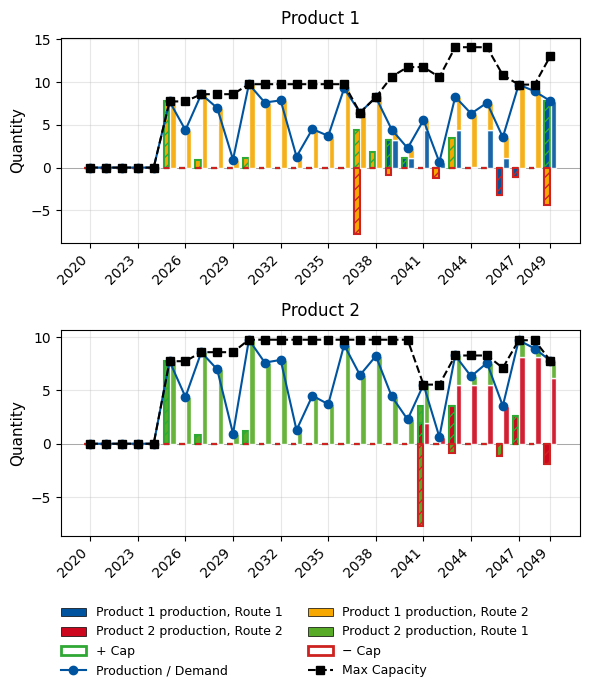

In [40]:
pp.plot_capacity_balance(detailed=True)

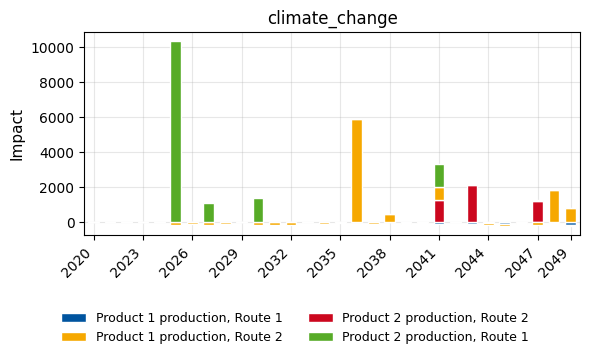

In [41]:
pp.plot_impacts()

2026-02-11 10:38:14.124 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


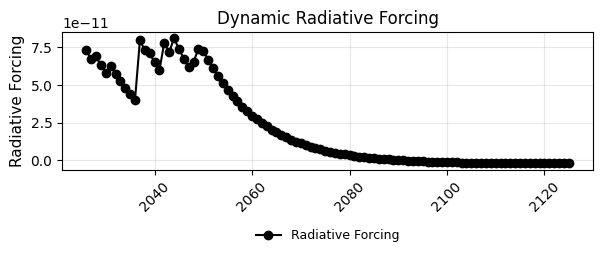

In [42]:
pp.plot_characterized_dynamic_inventory(
    base_lcia_method=("GWP", "example"), biosphere_database="biosphere3"
)